In [1]:
# Import necessary libraries for file handling, data manipulation, and visualization
import os 
import random
import numpy as np 
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt

# Import libraries for working with images and transformations
from PIL import Image
import cv2 as cv

# Import PyTorch modules for model building, data handling, and evaluation
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

# Import libraries for machine learning metrics and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import torchmetrics
from tqdm import tqdm

In [2]:
data_dir = "/Users/romerocruzsa/Workspace/Projects/Research/CAWT-URFI/data/APTOS/"
train_dir = data_dir+"train_images/"
test_dir = data_dir+"test_images/"

In [3]:
train_df = pd.read_csv(data_dir+"train.csv")
print(len(train_df))
display(train_df)

test_df = pd.read_csv(data_dir+"test.csv")
print(len(test_df))
display(test_df)

3662


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


1928


,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4
...,...
1923,ff2fd94448de
1924,ff4c945d9b17
1925,ff64897ac0d8
1926,ffa73465b705


In [4]:
# Mapping diagnosis to severity
severity_mapping = {
    0: 'No DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferative DR'
}

train_df['severity_desc'] = train_df['diagnosis'].map(severity_mapping)
display(train_df)

,id_code,diagnosis,severity_desc
0,000c1434d8d7,2,Moderate
1,001639a390f0,4,Proliferative DR
2,0024cdab0c1e,1,Mild
3,002c21358ce6,0,No DR
4,005b95c28852,0,No DR
...,...,...,...
3657,ffa47f6a7bf4,2,Moderate
3658,ffc04fed30e6,0,No DR
3659,ffcf7b45f213,2,Moderate
3660,ffd97f8cd5aa,0,No DR


In [5]:
# Mapping diagnosis to severity
severity_mapping = {
    0: [1,0,0,0,0],
    1: [0,1,0,0,0],
    2: [0,0,1,0,0],
    3: [0,0,0,1,0],
    4: [0,0,0,0,1]
}

train_df['one_hot_diagnosis'] = train_df['diagnosis'].map(severity_mapping)
display(train_df)

,id_code,diagnosis,severity_desc,one_hot_diagnosis
0,000c1434d8d7,2,Moderate,"[0, 0, 1, 0, 0]"
1,001639a390f0,4,Proliferative DR,"[0, 0, 0, 0, 1]"
2,0024cdab0c1e,1,Mild,"[0, 1, 0, 0, 0]"
3,002c21358ce6,0,No DR,"[1, 0, 0, 0, 0]"
4,005b95c28852,0,No DR,"[1, 0, 0, 0, 0]"
...,...,...,...,...
3657,ffa47f6a7bf4,2,Moderate,"[0, 0, 1, 0, 0]"
3658,ffc04fed30e6,0,No DR,"[1, 0, 0, 0, 0]"
3659,ffcf7b45f213,2,Moderate,"[0, 0, 1, 0, 0]"
3660,ffd97f8cd5aa,0,No DR,"[1, 0, 0, 0, 0]"


severity_desc
No DR               1805
Moderate             999
Mild                 370
Proliferative DR     295
Severe               193
Name: count, dtype: int64


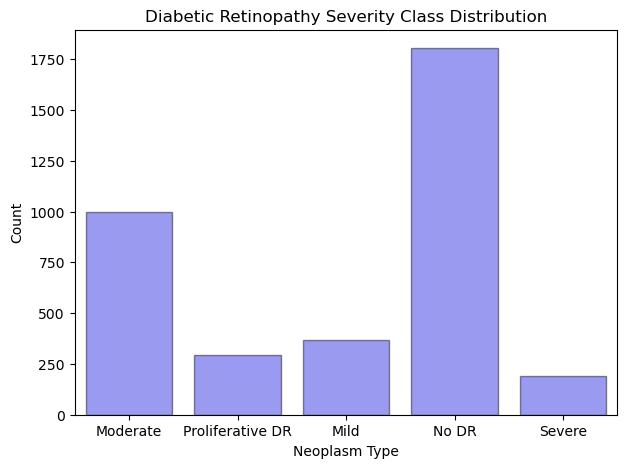

In [6]:
severity_counts = train_df['severity_desc'].value_counts()
print(severity_counts)

plt.figure(figsize=(7, 5))
sns.countplot(data=train_df, edgecolor='k', color='b', alpha=0.45, x='severity_desc')
plt.title('Diabetic Retinopathy Severity Class Distribution')
plt.xlabel('Neoplasm Type')
plt.ylabel('Count')
plt.show()

In [7]:
def load_images(dir, df):
    images = []
    labels = []
    descriptions = []

    for i, row in df.iterrows():
        if len(row) < 3:
            img_id = row['id_code']
            img_path = dir+img_id+".png"
        else:
            img_id = row['id_code']
            label = row['diagnosis']
            desc = row['severity_desc']
            img_path = dir+img_id+".png"

        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv.resize(img, (224, 224))  # Resize image to (224, 224)
        images.append(img)
        labels.append(label)
        descriptions.append(desc)
        
    return np.array(images), np.array(labels), np.array(descriptions)

train_images, train_labels, train_categories = load_images(train_dir, train_df)

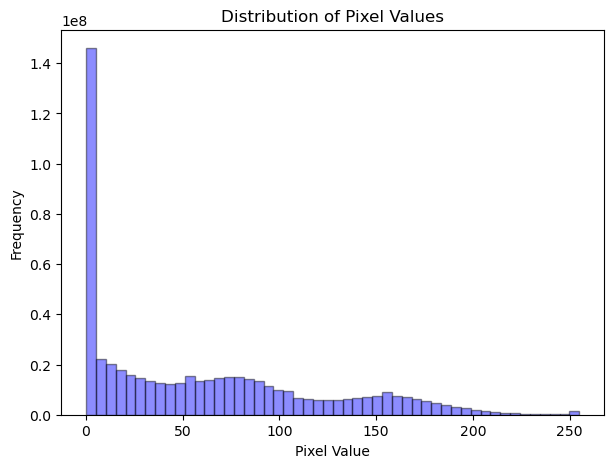

In [8]:
X_train = train_images.reshape(train_images.shape[0], -1)
pixel_values = X_train

plt.figure(figsize=(7, 5))
plt.hist(pixel_values.flatten(), edgecolor='k', color='b', alpha=0.45, bins=50)
# sns.histplot(pixel_values.flatten(), bins=50, kde=True)
plt.title('Distribution of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

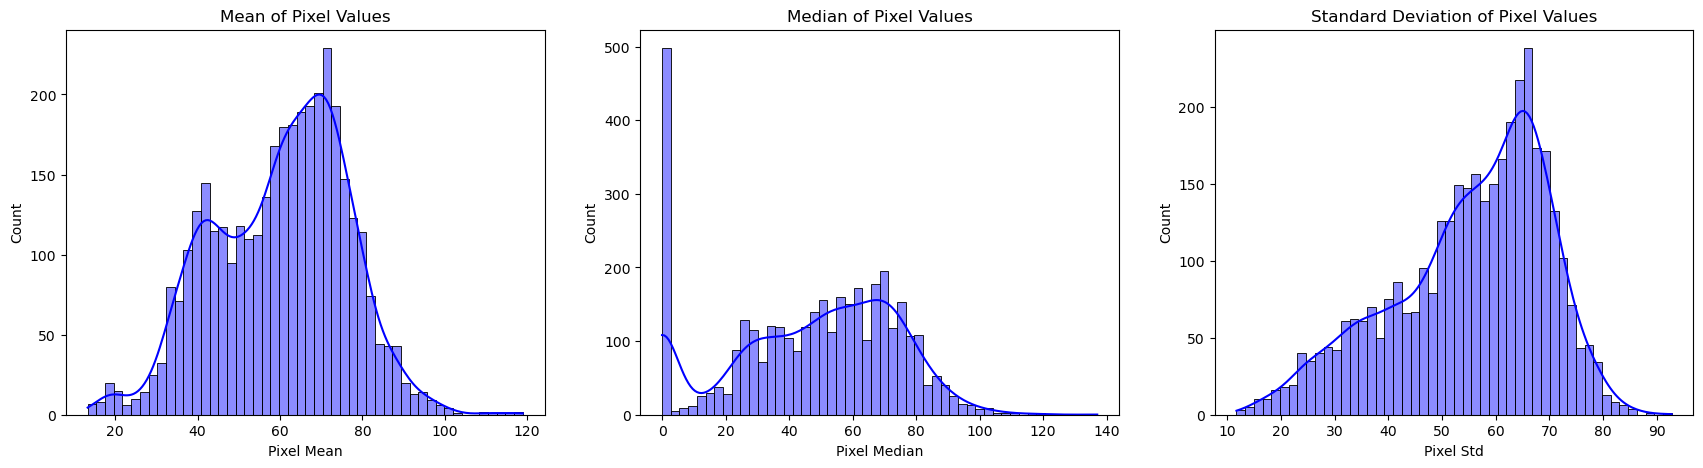

In [9]:
descriptive_stats_df = pd.DataFrame([])
pixel_mean = np.mean(pixel_values, axis=1)
pixel_median = np.median(pixel_values, axis=1)
pixel_std = np.std(pixel_values, axis=1)

descriptive_stats_df['Pixel Mean'] = pixel_mean
descriptive_stats_df['Pixel Median'] = pixel_median
descriptive_stats_df['Pixel Std'] = pixel_std

plt.figure(figsize=(21, 5))
plt.subplot(1, 3, 1)
sns.histplot(descriptive_stats_df['Pixel Mean'], bins=50, color='b', alpha=0.45, kde=True)
plt.title('Mean of Pixel Values')

plt.subplot(1, 3, 2)
sns.histplot(descriptive_stats_df['Pixel Median'], bins=50, color='b', alpha=0.45, kde=True)
plt.title('Median of Pixel Values')

plt.subplot(1, 3, 3)
sns.histplot(descriptive_stats_df['Pixel Std'], bins=50, color='b', alpha=0.45, kde=True)
plt.title('Standard Deviation of Pixel Values')

plt.show()

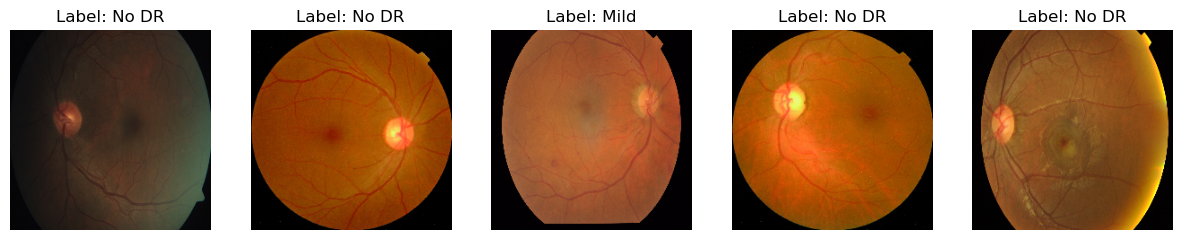

Some relations based on the images:
Image 2844 has label: No DR
Image 3421 has label: No DR
Image 331 has label: Mild
Image 2820 has label: No DR
Image 2344 has label: No DR


In [10]:
# Visualizing sample images and printing relations
num_samples = 5
sample_indices = random.sample(range(len(train_images)), num_samples)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(train_images[idx])
    plt.title(f"Label: {train_categories[idx]}")
    plt.axis('off')

plt.show()

# Print some relations based on the images (you can customize this based on your analysis)
print("Some relations based on the images:")
for idx in sample_indices:
    print(f"Image {idx} has label: {train_categories[idx]}")

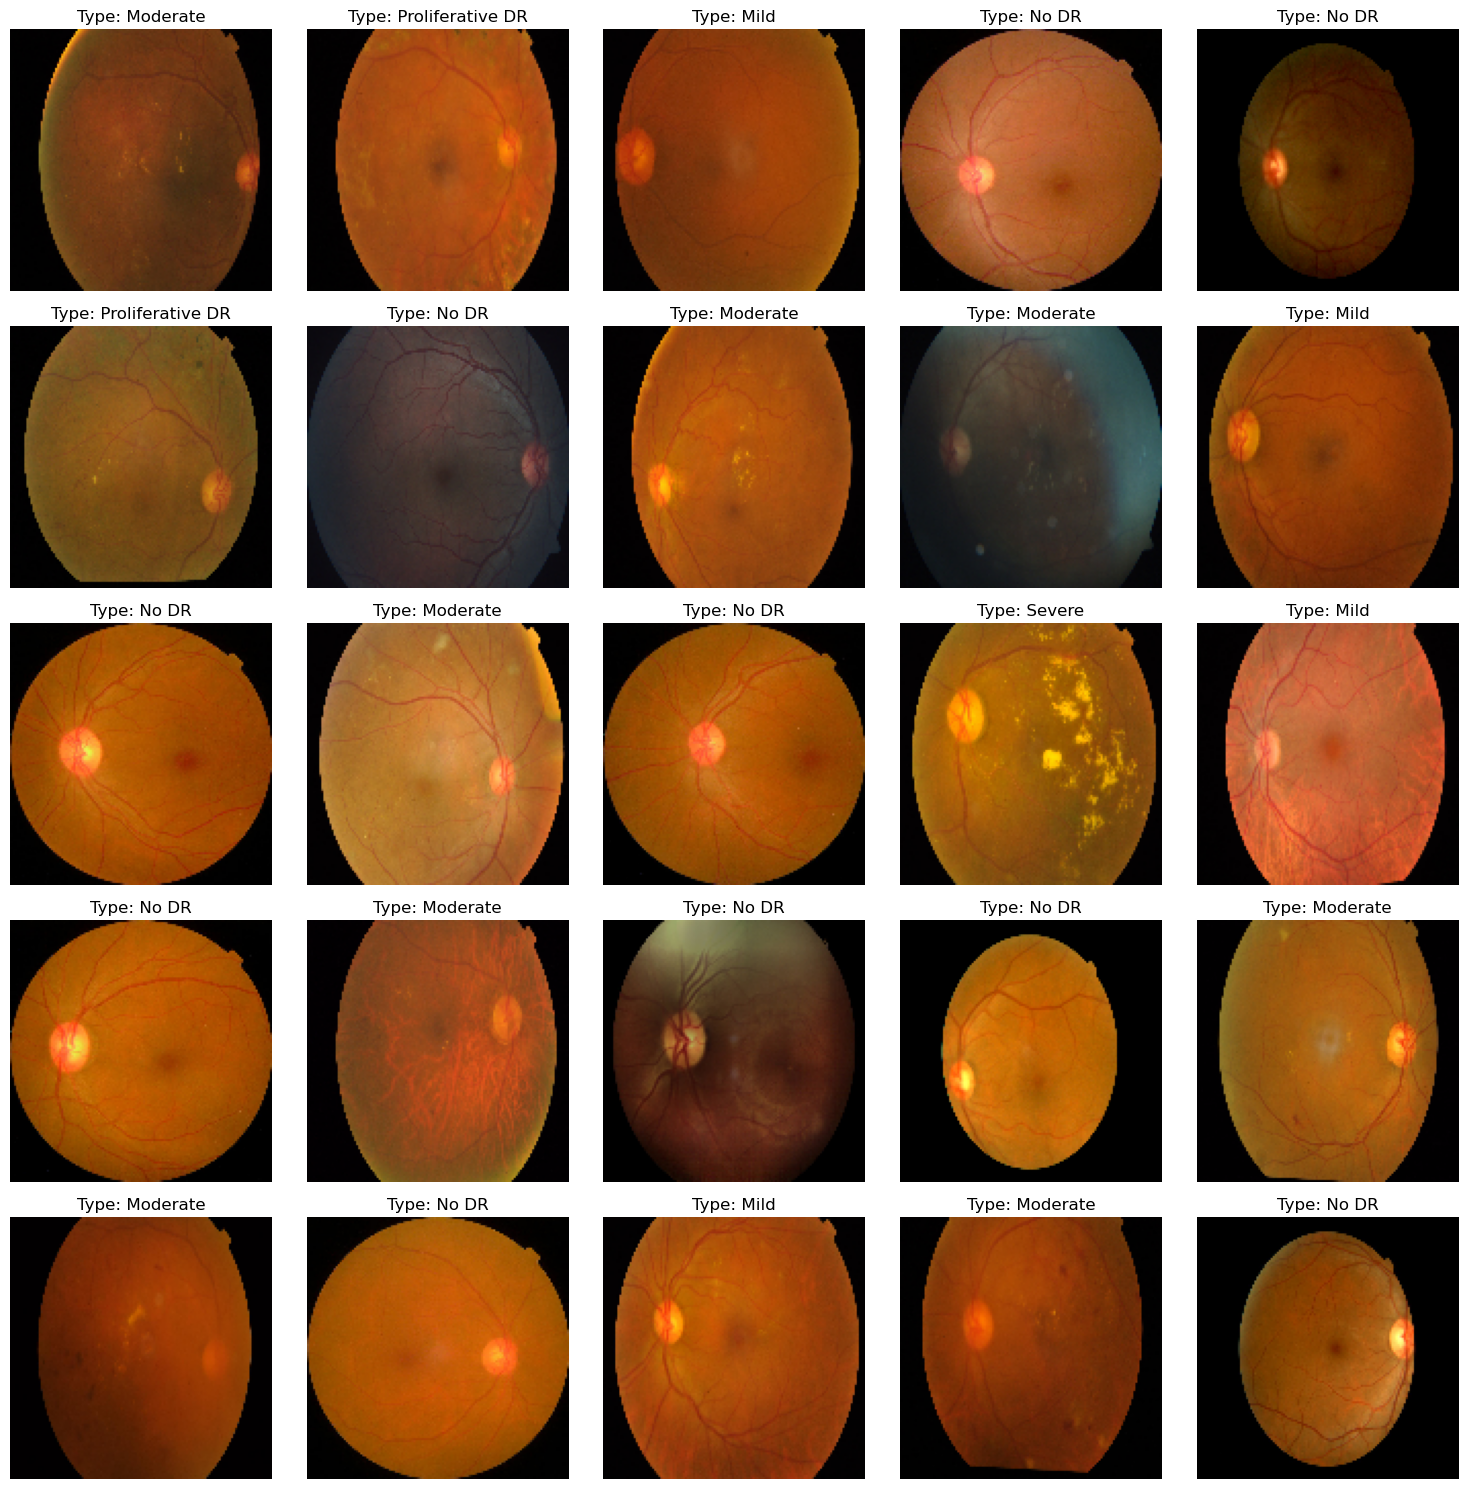

In [11]:
def plot_image_grid(df, dir, image_path, class_column, grid_size=(10, 10), image_size=(300, 300)):
    """
    Plots a grid of images from a DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing image paths and their respective classes.
    image_column (str): Column name in the DataFrame that contains image paths.
    class_column (str): Column name in the DataFrame that contains image classes.
    grid_size (tuple): Size of the grid (rows, cols).
    image_size (tuple): Size to which each image will be resized (width, height).
    
    Returns:
    None
    """
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))
    axes = axes.flatten()

    for i, (idx, row) in enumerate(df.iterrows()):
        if i >= grid_size[0] * grid_size[1]:
            break
        img_path = dir+row[image_path]+".png"
        img_class = row[class_column]
        
        # Read and resize the image
        img = cv.imread(img_path)
        if img is None:
            print(f"Error loading image at {img_path}")
            continue
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, image_size)
        
        # Plot the image
        axes[i].imshow(img)
        axes[i].set_title(f"Type: {img_class}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_image_grid(train_df, train_dir,
                image_path='id_code',
                class_column='severity_desc',
                grid_size=(5,5),
                image_size=(128,128))

In [12]:
device = torch.device('cpu')

# Check for macOS Apple Silicon compatibility
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    device = torch.device("mps")

print(f"Selected device: {device}")

Selected device: mps


In [13]:
device = torch.device('cpu')
print(f"[OVERRIDE] Selected device: {device}")

[OVERRIDE] Selected device: cpu


In [14]:
subset_length = round(len(train_df)*.10)
# subset_length = round(25)
print("Subset length:", subset_length)
sample_df = train_df.sample(subset_length)
display(sample_df)

Subset length: 366


,id_code,diagnosis,severity_desc,one_hot_diagnosis
73,05b1bb2bdb81,0,No DR,"[1, 0, 0, 0, 0]"
704,3286073a976e,0,No DR,"[1, 0, 0, 0, 0]"
2510,ae2c3f6312ef,0,No DR,"[1, 0, 0, 0, 0]"
1558,6d5a8362dd1e,0,No DR,"[1, 0, 0, 0, 0]"
3384,eabc7c716255,0,No DR,"[1, 0, 0, 0, 0]"
...,...,...,...,...
667,2f81ee5f2926,0,No DR,"[1, 0, 0, 0, 0]"
1355,5e52c9fe676f,2,Moderate,"[0, 0, 1, 0, 0]"
500,2399d68d407f,0,No DR,"[1, 0, 0, 0, 0]"
971,454792eb6e05,0,No DR,"[1, 0, 0, 0, 0]"


In [15]:
# Define any data augmentations or transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=np.random.rand()),
    # transforms.RandomVerticalFlip(p=np.random.rand()),
    # transforms.RandomRotation(degrees=np.random.randint(0,360)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets from CSV files (assuming you have a custom dataset class)
class DRImageDataset(Dataset):
    def __init__(self, dir, df, transform=None):
        """
        Initializes the dataset with a directory and DataFrame, and optional transformations.
        
        Parameters:
        dir (str): Path to the directory containing images.
        df (DataFrame): DataFrame containing image IDs and labels.
        transform (callable, optional): Optional transformations to be applied to the images.
        """
        self.dir = dir
        self.df = df
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        
        Returns:
        int: Number of samples.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieves the image and label at the specified index.
        
        Parameters:
        idx (int): Index of the sample to retrieve.
        
        Returns:
        tuple: (image, target, description) where image is the transformed image, target is the label, and description is the severity description.
        """
        row = self.df.iloc[idx]
        img_id = row['id_code']
        img_path = os.path.join(self.dir, img_id + ".png")
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        label = torch.FloatTensor(row['one_hot_diagnosis'])
        desc = row.get('severity_desc', 'Unknown')
        
        return img, label, desc

# Create the dataset
# image_dataset = DRImageDataset(train_dir, train_df, transform=transform)
image_dataset = DRImageDataset(train_dir, sample_df, transform=transform)

# Split the dataset
train_dataset, test_dataset = train_test_split(image_dataset, test_size=0.3, shuffle=True)
val_dataset, test_dataset = train_test_split(test_dataset, test_size=0.5, shuffle=True)

print(f"Train Dataset: {len(train_dataset)}, Val Dataset: {len(val_dataset)}, Test Dataset: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Train Dataset: 256, Val Dataset: 55, Test Dataset: 55


In [16]:
def train(dataloader, model, loss_fn, optimizer, cumulative_metrics):
    """
    Training loop for one epoch.
    
    Parameters:
    dataloader (DataLoader): DataLoader containing the training data.
    model (torch.nn.Module): PyTorch model to be trained.
    loss_fn (callable): Loss function.
    optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
    cumulative_metrics (CumulativeMetrics): Instance of CumulativeMetrics for tracking metrics.
    
    Returns:
    tuple: Average loss and average accuracy for the epoch.
    """
    model.train()
    size = len(dataloader.dataset)
    batch_losses = []
    batch_acc = []
    cumulative_metrics.reset()

    for _, (X, y, _) in tqdm(enumerate(dataloader), total=len(dataloader), desc="Training"):
        X, y = X.to(device), y.to(device)#.unsqueeze(1)
        y = y.to(torch.quint8)
        
        optimizer.zero_grad()
        pred = model(X)

        # logits = model(X)
        # probabilities = torch.softmax(logits, dim=1) # Convert logits to probabilities using softmax
        # predicted_classes = torch.argmax(probabilities, dim=1) # Get the predicted class (index of the highest probability)
        # pred = torch.nn.functional.one_hot(predicted_classes, num_classes=5).float() # Convert class indices to one-hot encoding

        loss = loss_fn(pred, y)        
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())        
        cumulative_metrics.update(pred, y)
    
    avg_loss = sum(batch_losses) / len(batch_losses)    
    performance_metrics = cumulative_metrics.get_cumulative_metrics()

    return avg_loss, performance_metrics

def eval(dataloader, model, loss_fn, mode, cumulative_metrics):
    """
    Testing loop to evaluate the model on the test dataset.
    
    Parameters:
    dataloader (DataLoader): DataLoader containing the test data.
    model (torch.nn.Module): PyTorch model to be evaluated.
    loss_fn (callable): Loss function.
    cumulative_metrics (CumulativeMetrics): Instance of CumulativeMetrics for tracking metrics.
    
    Returns:
    tuple: Average loss and average accuracy for the test dataset.
    """
    model.eval()
    size = len(dataloader.dataset)
    batch_losses = []
    cumulative_metrics.reset()

    if mode == "Testing":
        with torch.no_grad():
            for _, (X, y, _) in enumerate(dataloader):
                X, y = X.to(device), y.to(device)
                y = y.to(torch.quint8)

                pred = model(X)
                # logits = model(X)
                # probabilities = torch.softmax(logits, dim=1) # Convert logits to probabilities using softmax
                # predicted_classes = torch.argmax(probabilities, dim=1) # Get the predicted class (index of the highest probability)
                # pred = torch.nn.functional.one_hot(predicted_classes, num_classes=5).float() # Convert class indices to one-hot encoding
                
                loss = loss_fn(pred, y)

                batch_losses.append(loss.item())
                cumulative_metrics.update(pred, y)
        
        avg_loss = sum(batch_losses) / len(batch_losses)    
        performance_metrics = cumulative_metrics.get_cumulative_metrics()

    
    if mode == "Validation":
        with torch.no_grad():
            for _, (X, y, _) in tqdm(enumerate(dataloader), total=len(dataloader), desc="Validation"):
                X, y = X.to(device), y.to(device)
                y = y.to(torch.quint8)

                pred = model(X)
                # logits = model(X)
                # probabilities = torch.softmax(logits, dim=1) # Convert logits to probabilities using softmax
                # predicted_classes = torch.argmax(probabilities, dim=1) # Get the predicted class (index of the highest probability)
                # pred = torch.nn.functional.one_hot(predicted_classes, num_classes=5).float() # Convert class indices to one-hot encoding
                
                loss = loss_fn(pred, y)

                batch_losses.append(loss.item())
                cumulative_metrics.update(pred, y)
        
        avg_loss = sum(batch_losses) / len(batch_losses)    
        performance_metrics = cumulative_metrics.get_cumulative_metrics()
    
    return avg_loss, performance_metrics

In [17]:
# Load MobileNetV2 with pretrained weights disabled
mbnetv2_quantized = models.quantization.mobilenet_v2(pretrained=True, quantize=True)

# Modify the classifier to output 5 classes (corresponding to the severity levels)
mbnetv2_quantized.classifier[1] = torch.nn.Linear(in_features=1280, out_features=5)
mbnetv2_quantized = mbnetv2_quantized.to(device)

# Print the model summary
print(summary(mbnetv2_quantized))

/opt/anaconda3/envs/cawt-urfi/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/cawt-urfi/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_QuantizedWeights.IMAGENET1K_QNNPACK_V1`. You can also use `weights=MobileNet_V2_QuantizedWeights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                             Param #
QuantizableMobileNetV2                             --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─ConvReLU2d: 3-1                        --
│    │    └─Identity: 3-2                          --
│    │    └─Identity: 3-3                          --
│    └─QuantizableInvertedResidual: 2-2            --
│    │    └─Sequential: 3-4                        --
│    │    └─QFunctional: 3-5                       --
│    └─QuantizableInvertedResidual: 2-3            --
│    │    └─Sequential: 3-6                        --
│    │    └─QFunctional: 3-7                       --
│    └─QuantizableInvertedResidual: 2-4            --
│    │    └─Sequential: 3-8                        --
│    │    └─QFunctional: 3-9                       --
│    └─QuantizableInvertedResidual: 2-5            --
│    │    └─Sequential: 3-10                       --
│    │    └─QFunctional

/opt/anaconda3/envs/cawt-urfi/lib/python3.11/site-packages/torch/ao/quantization/utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(
/opt/anaconda3/envs/cawt-urfi/lib/python3.11/site-packages/torch/_utils.py:382: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


In [18]:
class CumulativeMetrics:
    def __init__(self, num_classes=5, device='cpu'):
        self.device = device
        self.num_classes = num_classes

        # Initialize torchmetrics for multiclass
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
        self.precision = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average="macro").to(device)
        self.dice = torchmetrics.Dice(num_classes=num_classes, average="macro").to(device)
        self.f1_score = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

        # For scikit-learn metrics, we'll store the true and predicted values for each batch
        self.y_true_all = []
        self.y_pred_all = []
        self.y_score_all = []

        self.reset()

    def reset(self):
        # Reset torchmetrics accumulators
        self.cum_acc = 0.0
        self.cum_prec = 0.0
        self.cum_dice = 0.0
        self.cum_f1 = 0.0
        self.num_batches = 0
        
        # Reset true and predicted values lists for sklearn
        self.y_true_all = []
        self.y_pred_all = []
        self.y_score_all = []

    def update(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        # Convert one-hot encoded y_true to class indices
        y_true_class = torch.argmax(y_true, dim=1)
        
        # Get the class predictions (argmax for multiclass classification)
        y_pred_class = torch.argmax(y_pred, dim=1)

        # Append predictions and true labels for scikit-learn metrics later
        self.y_true_all.extend(y_true_class.cpu().numpy())
        self.y_pred_all.extend(y_pred_class.cpu().numpy())
        self.y_score_all.extend(y_pred.detach().cpu().numpy())  # Probabilities/logits for AUC

        # Update cumulative torchmetrics
        acc = self.accuracy(y_pred_class, y_true_class).item()
        prec = self.precision(y_pred_class, y_true_class).item()
        dice = self.dice(y_pred_class, y_true_class).item()
        f1 = self.f1_score(y_pred_class, y_true_class).item()

        self.cum_acc += acc
        self.cum_prec += prec
        self.cum_dice += dice
        self.cum_f1 += f1
        self.num_batches += 1

    def get_cumulative_metrics(self):
        avg_acc = self.cum_acc / self.num_batches
        avg_prec = self.cum_prec / self.num_batches
        avg_dice = self.cum_dice / self.num_batches
        avg_f1 = self.cum_f1 / self.num_batches

        # # Convert true and predicted values to numpy arrays for sklearn
        # y_true_all_np = np.array(self.y_true_all)
        # y_pred_all_np = np.array(self.y_pred_all)
        # y_score_all_np = np.array(self.y_score_all)

        # # Confusion matrix using sklearn
        # cm = confusion_matrix(y_true_all_np, y_pred_all_np)

        # # AUC-ROC using sklearn (One-vs-Rest strategy for multi-class)
        # try:
        #     auc_roc = roc_auc_score(y_true_all_np, y_score_all_np, multi_class="ovr", average="macro")
        # except ValueError:
        #     auc_roc = float('nan')  # Handle case where AUC-ROC cannot be computed

        # Calculate FPR and TPR for each class using sklearn
        # fpr_dict = {}
        # tpr_dict = {}
        # for i in range(self.num_classes):
        #     fpr, tpr, _ = roc_curve(y_true_all_np == i, y_score_all_np[:, i])
        #     fpr_dict[i] = fpr
        #     tpr_dict[i] = tpr

        performance_metrics =  {
            "Accuracy": avg_acc,
            "Precision": avg_prec,
            "Dice Score": avg_dice,
            "F1 Score": avg_f1,
            # "auc_roc": auc_roc,
            # "confusion_matrix": cm,
            # "fpr": fpr_dict,
            # "tpr": tpr_dict
        }        
        return performance_metrics

In [19]:
# Initialize model, loss function, and optimizer
mbnetv2_quantized = mbnetv2_quantized.to(device)

# Binary Cross Entropy with Logits Loss function
# Adam optimizer with a learning rate of 0.001
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mbnetv2_quantized.parameters(), lr=0.001)

# Number of epochs to train the model
EPOCHS = 5

# Lists to store the average loss and accuracy for each epoch
mbnetv2_quantized_train_epoch_losses = []
mbnetv2_quantized_train_epoch_acc = []

mbnetv2_quantized_val_epoch_losses = []
mbnetv2_quantized_val_epoch_acc = []

print(f"[ Started Training... ]")
for epoch in range(EPOCHS):
    print(f"\n[Epoch {epoch + 1}/{EPOCHS}] ")
    train_loss, train_performance_metrics =  train(train_loader, mbnetv2_quantized, loss_fn, optimizer, CumulativeMetrics(num_classes=5, device=device))
    train_accuracy, train_precision, train_dice, train_f1 = train_performance_metrics.values()
    print(f"Training: \tLoss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Dice Score: {train_dice:.4f}, F1 Score: {train_f1:.4f}")

    val_loss, val_performance_metrics = eval(val_loader, mbnetv2_quantized, loss_fn, 'Validation', CumulativeMetrics(num_classes=5, device=device))
    val_accuracy, val_precision, val_dice, val_f1 = val_performance_metrics.values()
    print(f"Validation: \tLoss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Dice Score: {val_dice:.4f}, F1 Score: {val_f1:.4f}")
    
    mbnetv2_quantized_train_epoch_losses.append(train_loss)
    mbnetv2_quantized_val_epoch_losses.append(val_loss)
    mbnetv2_quantized_train_epoch_acc.append(train_accuracy)
    mbnetv2_quantized_val_epoch_acc.append(val_accuracy)

print("\n[ Finished Training! ]")

[ Started Training... ]

[Epoch 1/5] 


Training:   0%|          | 0/16 [00:00<?, ?it/s]


RuntimeError: empty_strided not supported on quantized tensors yet see https://github.com/pytorch/pytorch/issues/74540

In [ ]:
test_loss, test_performance_metrics = eval(test_loader, mbnetv2_quantized, loss_fn, 'Testing', CumulativeMetrics(num_classes=5, device=device))
test_accuracy, test_precision, test_dice, test_f1 = test_performance_metrics.values()
print(f"Testing: \tLoss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Dice Score: {test_dice:.4f}, F1 Score: {test_f1:.4f}")